# OBJECTIVE
- Performing naive bayes algorithm to amazon fine food reviews
- Techniques used - BOW , TFIDF
- Using Multinomial version of Naive bayes as because the multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification) and multinomial distribution normally requires integer feature counts

In [1]:
#importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
import scikitplot as skplt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\lenovo\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
print(filtered_data.shape)

(525814, 10)


In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
filtered_data['Score'].value_counts() #Data points in each class

positive    443777
negative     82037
Name: Score, dtype: int64

In [6]:
#Sorting the data taking productid as the parameter
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.shape

(525814, 10)

In [7]:
#Deleting the dublicates reviews which is created when user writed a review for the product, it automatically generates for the same product of different color etc
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [9]:
duplicate_data= pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 AND Id=44737 OR Id=64422 ORDER BY ProductID""", con)
print(duplicate_data)

      Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...  


In [10]:
#Dropping the data which has HelpfulnessNumerator<HelpfulnessDenominator which is impossible
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [12]:
print(final.shape)

(364171, 10)


In [13]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
from tqdm import tqdm
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:00<00:00, 673.70it/s]


In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...


In [128]:
final.shape

(364171, 11)

In [129]:
final_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [130]:
X_train_data = final_data[:264171]
X_test_data = final_data[264171:364171]
y_train = X_train_data['Score']
y_test = X_test_data['Score']
print("Data")
print(X_train_data.shape)
print(X_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(264171, 11)
(100000, 11)
Label
(264171,)
(100000,)


# BOW

In [19]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_data['CleanedText'])
X_test = count_vect.transform(X_test_data['CleanedText'])
print(X_train.shape)
print(X_test.shape)

(264171, 60276)
(100000, 60276)


In [28]:
# Importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Creating alpha values in the range from 10^-3 to 10^3
alpha = [] #creating empty list for alpha
i = 0.001
while(i<=1000):
    alpha.append(np.round(i,3))
    i *= 3

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:53<00:00,  8.74s/it]



The optimal value of alpha is 0.729.


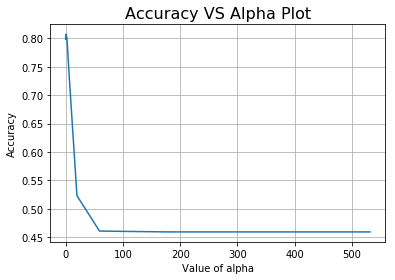


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [79.846 80.05  80.193 80.404 80.591 80.736 80.744 80.038 72.756 52.321
 46.084 45.935 45.936]


In [29]:
# determining best value of alpha
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [30]:
# instantiate learning model alpha = optimal_alpha
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

# fitting the model
model_bow_multinomial.fit(X_train,y_train)

# predict the response
pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  89.513
f1_score =  81.74891662072893
precision_score =  81.75252123854102
recall_score =  81.74531353243107


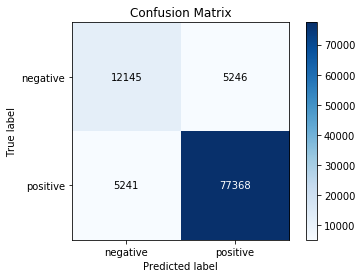

In [31]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)
print("precision_score = ",precision_score(y_test, pred, average='macro')*100)
print("recall_score = ",recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [32]:
True_Negative, False_Negative, False_Positive, True_Positive = confusion_matrix(y_test, pred).ravel()

Total_Positive = False_Negative + True_Positive
Total_Negative = True_Negative + False_Positive

TPR = True_Positive/Total_Positive 
FPR = False_Positive/Total_Negative
TNR = True_Negative/Total_Negative
FNR = False_Negative/ Total_Positive 
print("TPR = %.5f"%(TPR))
print("FPR = %.5f"%(FPR))
print("TNR = %.5f"%(TNR))
print("FNR = %.5f"%(FNR))

TPR = 0.93650
FPR = 0.30145
TNR = 0.69855
FNR = 0.06350


In [35]:
print("Actual Data")
print("------------")
print(X_test_data["Score"].value_counts())
print("\n")
print("After Prediction")
print("------------")
print("Positive =",Total_Positive)
print("Negative =",Total_Negative)

Actual Data
------------
positive    82609
negative    17391
Name: Score, dtype: int64


After Prediction
------------
Positive = 82614
Negative = 17386


In [41]:
print(model_bow_multinomial.classes_)
# Finding log probabilities
class_feature = model_bow_multinomial.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_feature = class_feature[0]
positive_feature = class_feature[1]

# Getting all feature names from the count vectorizer
feature_name = count_vect.get_feature_names()

#sorting
sorted_negative_feature = np.argsort(negative_feature)[::-1]
sorted_positive_feature = np.argsort(positive_feature)[::-1]

['negative' 'positive']


In [42]:
print("Negative feature top 10 :")
print("-------")
for i in list(sorted_negative_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],negative_feature[i]))
    
print("\nPositive feature top 10 :")
print("-------")
for i in list(sorted_positive_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],positive_feature[i]))

Negative feature top 10 :
-------
tast	 -->	-4.228348  
like	 -->	-4.308579  
product	 -->	-4.481159  
one	 -->	-4.754288  
flavor	 -->	-4.789130  
would	 -->	-4.900548  
tri	 -->	-4.905776  
good	 -->	-5.064903  
coffe	 -->	-5.092030  
use	 -->	-5.096412  

Positive feature top 10 :
-------
like	 -->	-4.440633  
tast	 -->	-4.510265  
good	 -->	-4.648948  
flavor	 -->	-4.667679  
love	 -->	-4.696167  
great	 -->	-4.719393  
use	 -->	-4.739908  
one	 -->	-4.795349  
product	 -->	-4.882274  
tea	 -->	-4.892647  


# TFIDF

In [131]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_data['CleanedText'])
X_test = tf_idf_vect.transform(X_test_data['CleanedText'])
print(X_train.shape)
print(X_test.shape)

(264171, 60276)
(100000, 60276)


In [132]:
# Importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Creating alpha values in the range from 10^-3 to 10^3
alpha = [] #creating empty list for alpha
i = 0.001
while(i<=1000):
    alpha.append(np.round(i,3))
    i *= 3

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:46<00:00,  8.20s/it]



The optimal value of alpha is 0.027.


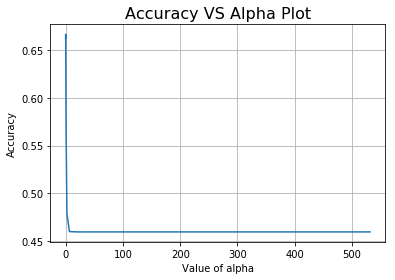


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [66.261 66.435 66.632 66.704 66.201 63.724 56.72  47.862 45.969 45.935
 45.936 45.936 45.936]


In [133]:
# determining best value of alpha
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [134]:
# instantiate learning model alpha = optimal_alpha
model_tfidf_multinomial = MultinomialNB(alpha = optimal_alpha)

# fitting the model
model_tfidf_multinomial.fit(X_train,y_train)

# predict the response
pred = model_tfidf_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  86.54899999999999
f1_score =  66.39939123081
precision_score =  87.28432391793031
recall_score =  62.72361870673669


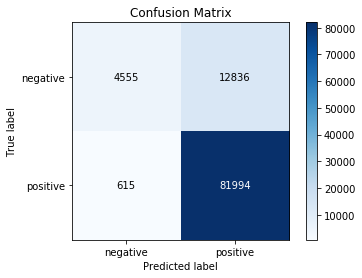

In [135]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)
print("precision_score = ",precision_score(y_test, pred, average='macro')*100)
print("recall_score = ",recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [136]:
True_Negative, False_Negative, False_Positive, True_Positive = confusion_matrix(y_test, pred).ravel()

Total_Positive = False_Negative + True_Positive
Total_Negative = True_Negative + False_Positive

TPR = True_Positive/Total_Positive 
FPR = False_Positive/Total_Negative
TNR = True_Negative/Total_Negative
FNR = False_Negative/ Total_Positive 
print("TPR = %.5f"%(TPR))
print("FPR = %.5f"%(FPR))
print("TNR = %.5f"%(TNR))
print("FNR = %.5f"%(FNR))

TPR = 0.86464
FPR = 0.11896
TNR = 0.88104
FNR = 0.13536


In [137]:
print("Actual Data")
print("------------")
print(X_test_data["Score"].value_counts())
print("\n")
print("After Prediction")
print("------------")
print("Positive =",Total_Positive)
print("Negative =",Total_Negative)

Actual Data
------------
positive    82609
negative    17391
Name: Score, dtype: int64


After Prediction
------------
Positive = 94830
Negative = 5170


In [140]:
print(model_tfidf_multinomial.classes_)
# Finding log probabilities
class_feature = model_tfidf_multinomial.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_feature = class_feature[0]
positive_feature = class_feature[1]

# Getting all feature names from the count vectorizer
feature_name = tf_idf_vect.get_feature_names()

#sorting
sorted_negative_feature = np.argsort(negative_feature)[::-1]
sorted_positive_feature = np.argsort(positive_feature)[::-1]

['negative' 'positive']


In [143]:
print("Negative feature top 10 :")
print("-------")
for i in list(sorted_negative_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],negative_feature[i]))
    
print("\nPositive feature top 10 :")
print("-------")
for i in list(sorted_positive_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],positive_feature[i]))

Negative feature top 10 :
-------
tast	 -->	-4.835084  
like	 -->	-4.987042  
product	 -->	-5.036189  
would	 -->	-5.326079  
flavor	 -->	-5.343088  
coffe	 -->	-5.359105  
one	 -->	-5.376012  
tri	 -->	-5.473543  
buy	 -->	-5.495681  
order	 -->	-5.504335  

Positive feature top 10 :
-------
great	 -->	-5.064847  
love	 -->	-5.077613  
tast	 -->	-5.140636  
good	 -->	-5.142874  
like	 -->	-5.158900  
tea	 -->	-5.177470  
flavor	 -->	-5.214627  
coffe	 -->	-5.246916  
product	 -->	-5.317709  
use	 -->	-5.332519  


### Trying to improve the percentageof each scores by adding words from summary to text and then again performing the bow and tfidf techniques

In [148]:
#Again

In [149]:
final_data.shape

(364171, 11)

In [150]:
final_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


In [151]:
final_data["Combined_Text"] = final_data['Text'] + ' ' + final_data['Summary']

In [152]:
print("*Text* :: ",final_data['Text'][0])
print("*Summary* :: ",final_data['Summary'][0])
print("*Combined* :: ",final_data["Combined_Text"][0])


*Text* ::  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
*Summary* ::  Good Quality Dog Food
*Combined* ::  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most. Good Quality Dog Food


In [153]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
from tqdm import tqdm
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final_data['Combined_Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:41<00:00, 626.39it/s]


In [154]:
final_data['Cleaned_combined']=final_string #adding a column of Cleaned_combined which displays the data after pre-processing of the review 
final_data['Cleaned_combined']=final_data['Cleaned_combined'].str.decode("utf-8")
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Combined_Text,Cleaned_combined
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...


In [155]:
X_train_data = final_data[:264171]
X_test_data = final_data[264171:364171]
y_train = X_train_data['Score']
y_test = X_test_data['Score']
print("Data")
print(X_train_data.shape)
print(X_test_data.shape)
print("Label")
print(y_train.shape)
print(y_test.shape)

Data
(264171, 13)
(100000, 13)
Label
(264171,)
(100000,)


# BOW

In [172]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train_data['Cleaned_combined'])
X_test = count_vect.transform(X_test_data['Cleaned_combined'])
print(X_train.shape)
print(X_test.shape)

(264171, 63890)
(100000, 63890)


In [173]:
# Importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Creating alpha values in the range from 10^-3 to 10^3
alpha = [] #creating empty list for alpha
i = 0.001
while(i<=1000):
    alpha.append(np.round(i,3))
    i *= 3

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:02<00:00,  9.56s/it]



The optimal value of alpha is 0.729.


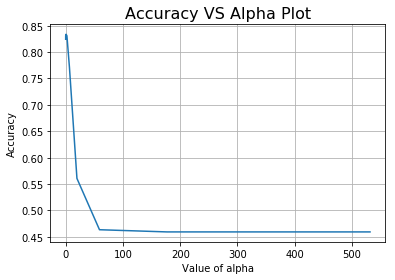


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [82.435 82.626 82.812 83.012 83.178 83.294 83.383 83.083 77.168 56.069
 46.351 45.936 45.936]


In [174]:
# determining best value of alpha
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [175]:
# instantiate learning model alpha = optimal_alpha
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

# fitting the model
model_bow_multinomial.fit(X_train,y_train)

# predict the response
pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  90.813
f1_score =  84.27198358700288
precision_score =  83.73654683373397
recall_score =  84.84052854375908


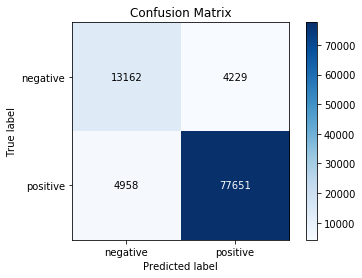

In [176]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)
print("precision_score = ",precision_score(y_test, pred, average='macro')*100)
print("recall_score = ",recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [177]:
True_Negative, False_Negative, False_Positive, True_Positive = confusion_matrix(y_test, pred).ravel()

Total_Positive = False_Negative + True_Positive
Total_Negative = True_Negative + False_Positive

TPR = True_Positive/Total_Positive 
FPR = False_Positive/Total_Negative
TNR = True_Negative/Total_Negative
FNR = False_Negative/ Total_Positive 
print("TPR = %.5f"%(TPR))
print("FPR = %.5f"%(FPR))
print("TNR = %.5f"%(TNR))
print("FNR = %.5f"%(FNR))

TPR = 0.94835
FPR = 0.27362
TNR = 0.72638
FNR = 0.05165


In [178]:
print("Actual Data")
print("------------")
print(X_test_data["Score"].value_counts())
print("\n")
print("After Prediction")
print("------------")
print("Positive =",Total_Positive)
print("Negative =",Total_Negative)

Actual Data
------------
positive    82609
negative    17391
Name: Score, dtype: int64


After Prediction
------------
Positive = 81880
Negative = 18120


In [179]:
print(model_bow_multinomial.classes_)
# Finding log probabilities
class_feature = model_bow_multinomial.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_feature = class_feature[0]
positive_feature = class_feature[1]

# Getting all feature names from the count vectorizer
feature_name = count_vect.get_feature_names()

#sorting
sorted_negative_feature = np.argsort(negative_feature)[::-1]
sorted_positive_feature = np.argsort(positive_feature)[::-1]

['negative' 'positive']


In [180]:
print("Negative feature top 10 :")
print("-------")
for i in list(sorted_negative_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],negative_feature[i]))
    
print("\nPositive feature top 10 :")
print("-------")
for i in list(sorted_positive_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],positive_feature[i]))

Negative feature top 10 :
-------
tast	 -->	-4.176562  
like	 -->	-4.296535  
product	 -->	-4.479295  
flavor	 -->	-4.767179  
one	 -->	-4.788565  
would	 -->	-4.943865  
tri	 -->	-4.953348  
good	 -->	-4.966215  
coffe	 -->	-5.068428  
use	 -->	-5.125153  

Positive feature top 10 :
-------
great	 -->	-4.418422  
like	 -->	-4.467804  
tast	 -->	-4.477669  
good	 -->	-4.487088  
love	 -->	-4.579291  
flavor	 -->	-4.665427  
use	 -->	-4.791853  
tea	 -->	-4.816060  
product	 -->	-4.830119  
one	 -->	-4.835603  


# TFIDF

In [156]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_data['Cleaned_combined'])
X_test = tf_idf_vect.transform(X_test_data['Cleaned_combined'])
print(X_train.shape)
print(X_test.shape)

(264171, 63890)
(100000, 63890)


In [157]:
# Importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Creating alpha values in the range from 10^-3 to 10^3
alpha = [] #creating empty list for alpha
i = 0.001
while(i<=1000):
    alpha.append(np.round(i,3))
    i *= 3

# empty list cv_scores that will hold cross-validation scores
cv_scores = []

# performing 10-fold cross validation on train data
for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', n_jobs=-1)
    cv_scores.append(scores.mean()) 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:47<00:00,  8.15s/it]



The optimal value of alpha is 0.027.


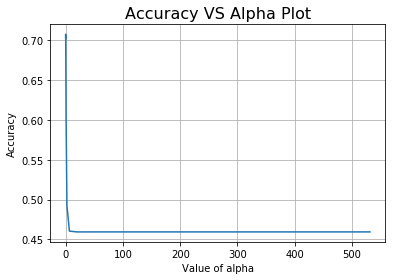


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [70.237 70.458 70.698 70.769 70.303 67.842 60.316 49.243 46.037 45.935
 45.936 45.936 45.936]


In [158]:
# determining best value of alpha
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [159]:
# instantiate learning model alpha = optimal_alpha
model_tfidf_multinomial = MultinomialNB(alpha = optimal_alpha)

# fitting the model
model_tfidf_multinomial.fit(X_train,y_train)

# predict the response
pred = model_tfidf_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  87.738
f1_score =  70.69600501136074
precision_score =  88.975124529424
recall_score =  66.13070458241911


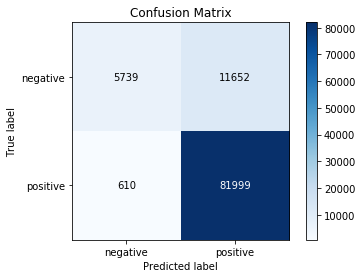

In [160]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)
print("precision_score = ",precision_score(y_test, pred, average='macro')*100)
print("recall_score = ",recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [161]:
True_Negative, False_Negative, False_Positive, True_Positive = confusion_matrix(y_test, pred).ravel()

Total_Positive = False_Negative + True_Positive
Total_Negative = True_Negative + False_Positive

TPR = True_Positive/Total_Positive 
FPR = False_Positive/Total_Negative
TNR = True_Negative/Total_Negative
FNR = False_Negative/ Total_Positive 
print("TPR = %.5f"%(TPR))
print("FPR = %.5f"%(FPR))
print("TNR = %.5f"%(TNR))
print("FNR = %.5f"%(FNR))

TPR = 0.87558
FPR = 0.09608
TNR = 0.90392
FNR = 0.12442


In [162]:
print("Actual Data")
print("------------")
print(X_test_data["Score"].value_counts())
print("\n")
print("After Prediction")
print("------------")
print("Positive =",Total_Positive)
print("Negative =",Total_Negative)

Actual Data
------------
positive    82609
negative    17391
Name: Score, dtype: int64


After Prediction
------------
Positive = 93651
Negative = 6349


In [163]:
print(model_tfidf_multinomial.classes_)
# Finding log probabilities
class_feature = model_tfidf_multinomial.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_feature = class_feature[0]
positive_feature = class_feature[1]

# Getting all feature names from the count vectorizer
feature_name = tf_idf_vect.get_feature_names()

#sorting
sorted_negative_feature = np.argsort(negative_feature)[::-1]
sorted_positive_feature = np.argsort(positive_feature)[::-1]

['negative' 'positive']


In [164]:
print("Negative feature top 10 :")
print("-------")
for i in list(sorted_negative_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],negative_feature[i]))
    
print("\nPositive feature top 10 :")
print("-------")
for i in list(sorted_positive_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_name[i],positive_feature[i]))

Negative feature top 10 :
-------
tast	 -->	-4.809819  
like	 -->	-4.993000  
product	 -->	-5.075751  
flavor	 -->	-5.333150  
coffe	 -->	-5.345334  
would	 -->	-5.384816  
one	 -->	-5.425288  
disappoint	 -->	-5.494400  
buy	 -->	-5.502796  
tri	 -->	-5.532694  

Positive feature top 10 :
-------
great	 -->	-4.873781  
love	 -->	-5.015109  
good	 -->	-5.033500  
tea	 -->	-5.079043  
tast	 -->	-5.129286  
coffe	 -->	-5.156811  
like	 -->	-5.204510  
flavor	 -->	-5.226146  
product	 -->	-5.289252  
use	 -->	-5.399474  


# RESULT

In [193]:
from IPython.display import HTML, display
import tabulate
table = [["S.NO.","MODEL","Best alpha","F1_SCORE","Test Accuracy"],
         ["1","BOW[Text]","0.729","81.748916","89.513"],
         ["2","BOW[Text+Summary]","0.729","84.271983","90.813"],
         ["3","TF-IDF[Text]","0.027","66.39939","86.54899"],
         ["4","TF-IDF[Text+Summary]","0.027","70.696005","87.738"]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

S.NO.,MODEL,Best alpha,F1_SCORE,Test Accuracy
1,BOW[Text],0.729,81.748916,89.513
2,BOW[Text+Summary],0.729,84.271983,90.813
3,TF-IDF[Text],0.027,66.39939,86.54899
4,TF-IDF[Text+Summary],0.027,70.696005,87.738


# CONCLUSION

- > As Stated in the result table that when summary of every product is added to the actual reviews then it gives better performance as compared to the model which takes only the text of the reviews in both bow and tfidf vectorization
- > But when summary is also take then many points of the negative class gets predicted to be positive class in the model which decreses the stability of the model, and it makes model more biased towards positive points.
- > Bow vectorizer[TEXT] is the best model as compared to tfidf vectorizer as it gives better stats
- > BOW Vectorizer[TEXT] is performing well in unseen data and hence its stats are good.
- > Naive bayes is the simplest algorithm and it takes very much less time then KNN.